## Calibrating a Classifier after balancing the data
- Here in this notebook, we'll basically try to compare the performance, calibration probabilities of classifiers (Logistic Regression and RF classifiers ) on an imbalanced dataset
- We'll check the model performance on raw data and resampled data before and after calibration

In [10]:
# import libraries

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# for preparation
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE
# evaluation
from sklearn.metrics import(
    roc_auc_score,
    brier_score_loss,
)

# to get the calibrated points
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [3]:
# import data
path = '..\ImbalanceData_Analysis\kdd2004.csv'
df = pd.read_csv(path)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,target
0,52.0,32.69,0.30,2.5,20.0,1256.8,-0.89,0.33,11.0,-55.0,...,1595.1,-1.64,2.83,-2.0,-50.0,445.2,-0.35,0.26,0.76,-1
1,58.0,33.33,0.00,16.5,9.5,608.1,0.50,0.07,20.5,-52.5,...,762.9,0.29,0.82,-3.0,-35.0,140.3,1.16,0.39,0.73,-1
2,77.0,27.27,-0.91,6.0,58.5,1623.6,-1.40,0.02,-6.5,-48.0,...,1491.8,0.32,-1.29,0.0,-34.0,658.2,-0.76,0.26,0.24,-1
3,41.0,27.91,-0.35,3.0,46.0,1921.6,-1.36,-0.47,-32.0,-51.5,...,2047.7,-0.98,1.53,0.0,-49.0,554.2,-0.83,0.39,0.73,-1
4,50.0,28.00,-1.32,-9.0,12.0,464.8,0.88,0.19,8.0,-51.5,...,479.5,0.68,-0.59,2.0,-36.0,-6.9,2.02,0.14,-0.23,-1


In [4]:
# set X and y

X = df.drop('target', axis = 1)
y = df['target'].map({-1:0,1:1})

X.shape, y.shape


((145751, 74), (145751,))

In [5]:
y.value_counts()

0    144455
1      1296
Name: target, dtype: int64

In [6]:
# split the data into train and test

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.3,
                                                    random_state=0)

X_train.shape, X_test.shape

((102025, 74), (43726, 74))

In [7]:
y_train.value_counts()

0    101134
1       891
Name: target, dtype: int64

In [8]:
y_train.value_counts()/len(y_train)

0    0.991267
1    0.008733
Name: target, dtype: float64

## Random Forest and Logistic Reg

In [14]:
# lets initialize the estimator objects

rf = RandomForestClassifier(n_estimators=100,
                            n_jobs=2,
                            max_depth=5,
                            random_state=0)

logit = LogisticRegression(penalty='l2',
                           solver='newton-cg',
                           max_iter=10,
                           n_jobs=2,
                          random_state=0)

In [12]:
# initialize the random under sampler and SMOTE

rus = RandomUnderSampler(sampling_strategy='auto',
                         random_state=0,
                         replacement=True)

X_rus, y_rus = rus.fit_resample(X_train,y_train)
print(X_rus.shape, y_rus.shape)

# SMOTE
sm = BorderlineSMOTE(sampling_strategy='auto',
                     random_state=0,
                     k_neighbors=5,
                     m_neighbors=10,
                     kind='borderline-1',
                     n_jobs=2)

X_sm, y_sm = sm.fit_resample(X_train,y_train)
print(X_sm.shape, y_sm.shape)

(1782, 74) (1782,)
(202268, 74) (202268,)


In [15]:
# get the ROC scores 

for model in [rf, logit]:
    
    print('{}'.format(type(model).__name__))
    # for raw data
    model.fit(X_train, y_train)
    preds_test = model.predict_proba(X_test)[:,1]
    print('ROC score for Raw data : {}'.format(roc_auc_score(y_test,preds_test)))
    print('Brier score for Raw data : {}'.format(brier_score_loss(y_test,preds_test)))
    print()
    
    # for RUS data
    model.fit(X_rus, y_rus)
    preds_test = model.predict_proba(X_test)[:,1]
    print('ROC score for RUS data : {}'.format(roc_auc_score(y_test,preds_test)))
    print('Brier score for RUS data : {}'.format(brier_score_loss(y_test,preds_test)))
    print()
    
    # for SMOTE data
    model.fit(X_sm, y_sm)
    preds_test = model.predict_proba(X_test)[:,1]
    print('ROC score for SMOTE data : {}'.format(roc_auc_score(y_test,preds_test)))
    print('Brier score for SMOTE data : {}'.format(brier_score_loss(y_test,preds_test)))


RandomForestClassifier
ROC score for Raw data : 0.97921610737643
Brier score for Raw data : 0.003146995327550594

ROC score for RUS data : 0.989311715784635
Brier score for RUS data : 0.03437109203933689

ROC score for SMOTE data : 0.9840786594247195
Brier score for SMOTE data : 0.017852617210707016
LogisticRegression
ROC score for Raw data : 0.9256916712192443
Brier score for Raw data : 0.0043047286225562295

ROC score for RUS data : 0.9759898045056129
Brier score for RUS data : 0.054072585621275045

ROC score for SMOTE data : 0.9732985542038888
Brier score for SMOTE data : 0.042516732575077903


- So, both the models are performing better on the resampled data as we can see in the ROC AUC scores
- Lets now check how the calibration probabilities are based on these data. We are expecting lower brier scores for the resampled data sets as resampling eventually distort the relationship between the data from the true real data 

In [16]:
# lets write a function to plot the calibration curve

def plot_calibration_curve(y_test,preds_test,bins):
    
    plt.figure(figsize=(10,14))
    plt.subplot(2,1,1)
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, preds_test, n_bins=bins,strategy='uniform')
    plt.plot(mean_predicted_value, fraction_of_positives,label='Random Forest')


    # draw the perfect calibrated line
    plt.plot(np.linspace(0,1,10),np.linspace(0,1,10),linestyle='--',c='red',label='Perfect Calibration')
    plt.legend(loc='best');
    plt.title('Calibration Curve')
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of positive examples')

    # lets plot the distribution of the predicted probabilities as well
    plt.subplot(2,1,2)
    plt.hist(preds_test,range=(0,1),bins=bins,density=True,alpha = 0.5)
    plt.title('Density')
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of examples')

    plt.show()

## Calibration - RAW Data

RandomForestClassifier


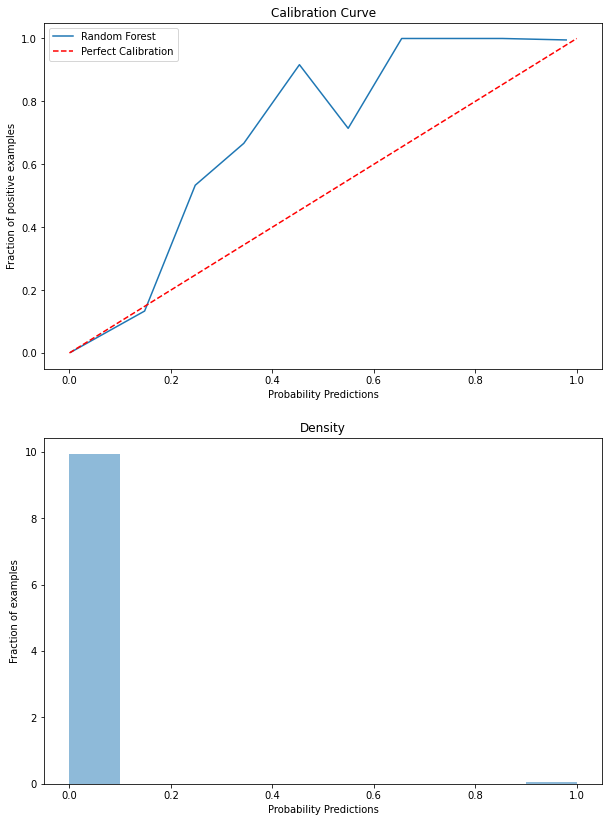

LogisticRegression


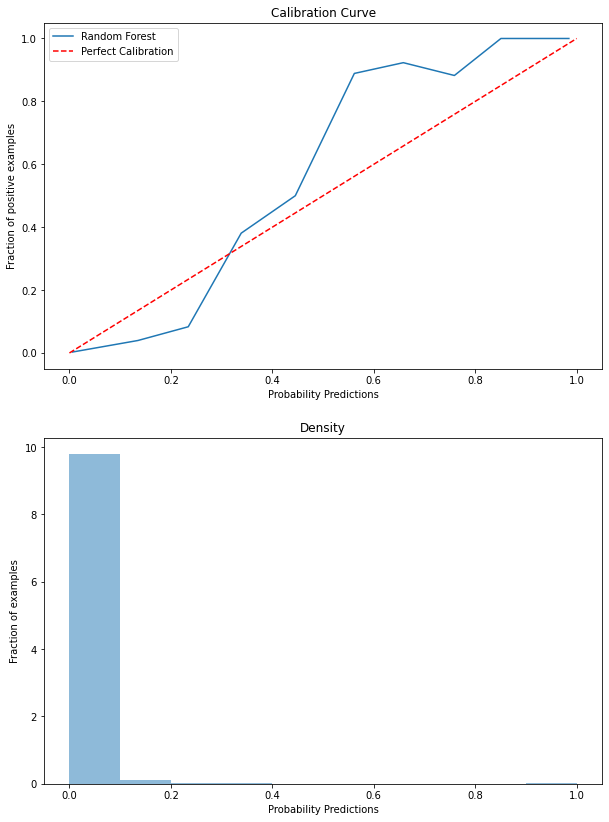

In [19]:
# calling the calibration curve function
# for raw data

for model in [rf, logit]:    
    
    print('{}'.format(type(model).__name__))
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)[:,1]
    
    plot_calibration_curve(y_test,preds,10)

- As expected, Logistic Regression returns a fairly well calibrated probability.
- Even for LOgistic model, the right side of the curve are little distorted as there are fairly less observations as the data is highly imbalanced.

## Calibration - RUS Data

RandomForestClassifier


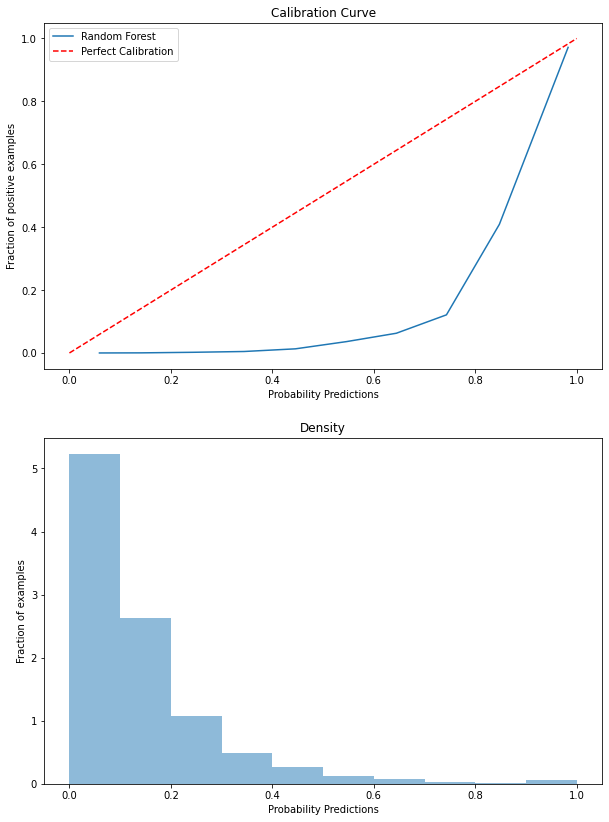

LogisticRegression


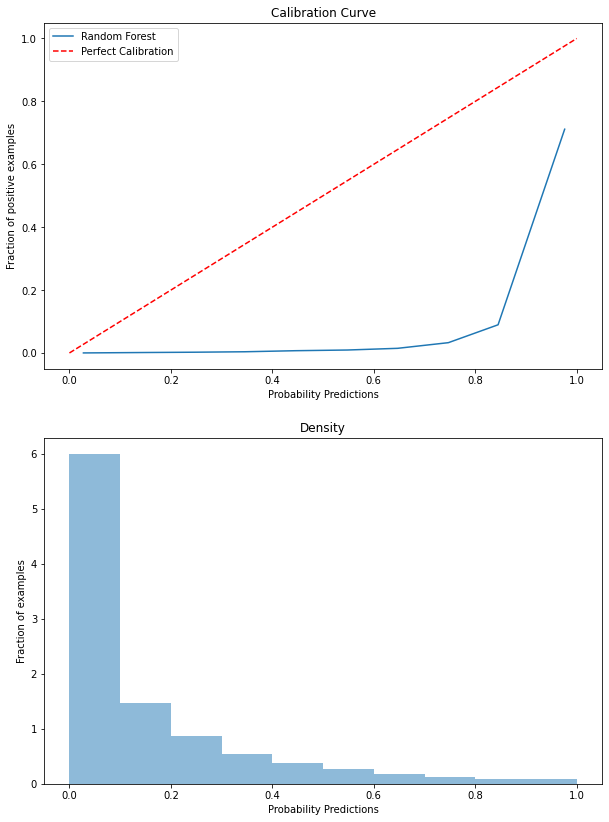

In [20]:
# calling the calibration curve function
# for RUS data

for model in [rf, logit]:    
    
    print('{}'.format(type(model).__name__))
    model.fit(X_rus, y_rus)
    preds = model.predict_proba(X_test)[:,1]
    
    plot_calibration_curve(y_test,preds,10)

As expected, under-sampling distorts the calibration. This is, because the class distributions in train and test set are different.

## Calibration with SMOTE

RandomForestClassifier


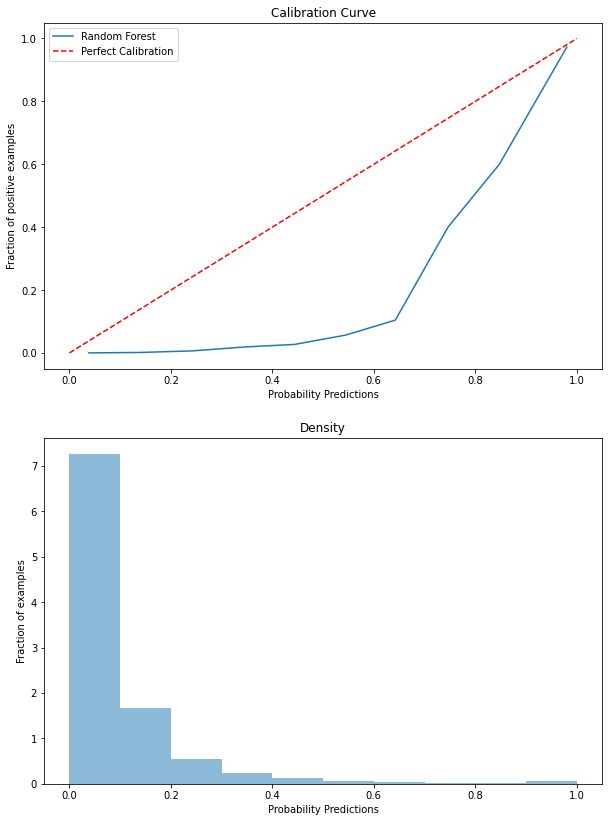

LogisticRegression


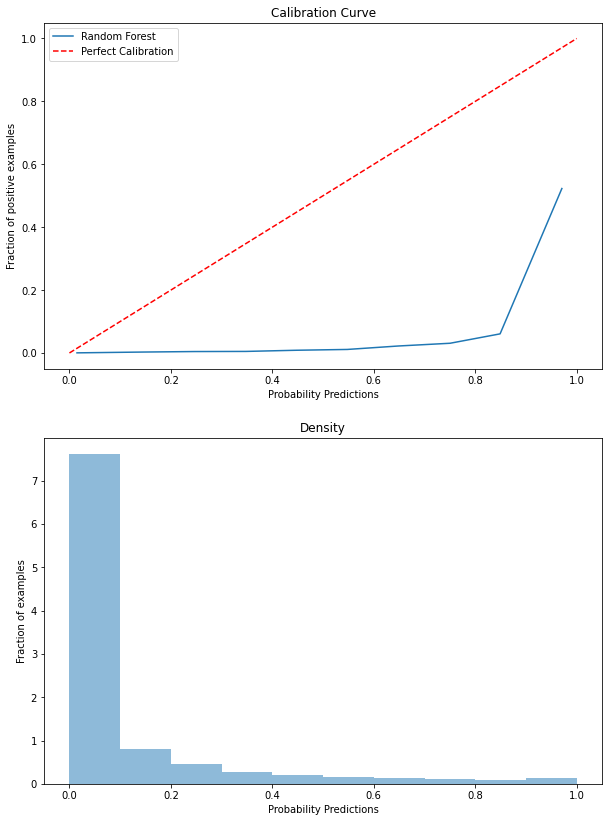

In [21]:
# calling the calibration curve function
# for SMOTE data

for model in [rf, logit]:    
    
    print('{}'.format(type(model).__name__))
    model.fit(X_sm, y_sm)
    preds = model.predict_proba(X_test)[:,1]
    
    plot_calibration_curve(y_test,preds,10)

As expected, under-sampling distorts the calibration. This is, because the class distributions in train and test set are different.

## Probability Re-calibration
- Now we'll try to calibrate our models that are trained with Sampled Datasets

### Random Under Sampled Data

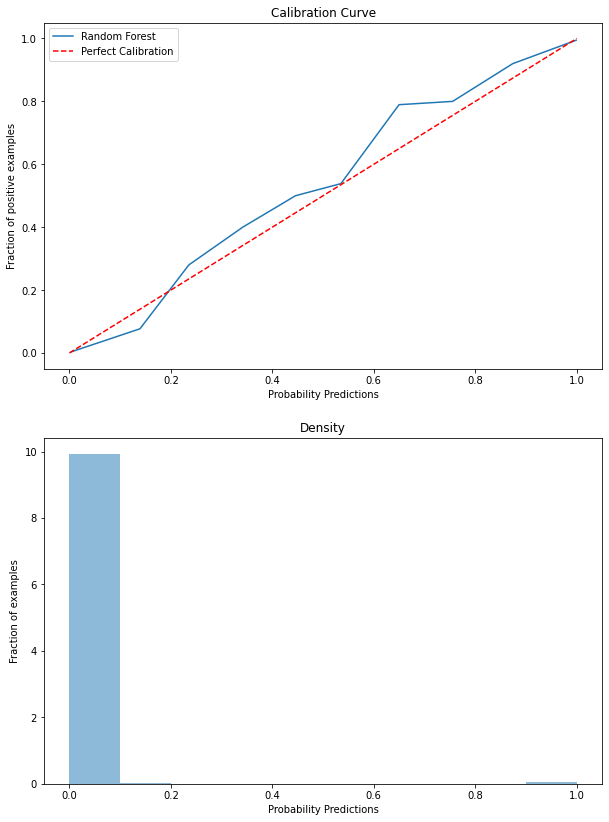

In [22]:
# for Logistic Model - RUS
# first fit log model on rus data
logit.fit(X_rus,y_rus)

# create a calibrated classifier on that model
clf = CalibratedClassifierCV(base_estimator=logit, n_jobs=2, cv=5, method='isotonic')

# fitting the clf to our test data
clf.fit(X_test,y_test) 
# get the predictions
preds = clf.predict_proba(X_test)[:,1]

# plotting the calibration curve
plot_calibration_curve(y_test,preds,bins=10)

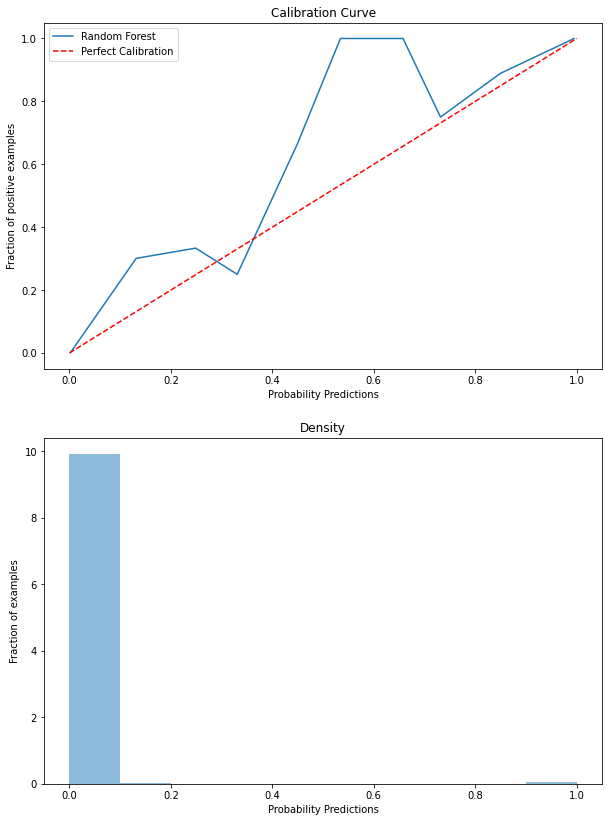

In [23]:
# for RF Model - RUS
# first fit log model on rus data
rf.fit(X_rus,y_rus)

# create a calibrated classifier on that model
clf = CalibratedClassifierCV(base_estimator=rf, n_jobs=2, cv=5, method='isotonic')

# fitting the clf to our test data
clf.fit(X_test,y_test) 
# get the predictions
preds = clf.predict_proba(X_test)[:,1]

# plotting the calibration curve
plot_calibration_curve(y_test,preds,bins=10)

- Now we can see much better calibrated probabilities for both the models that are trained on the under sampled data

### on SMOTE

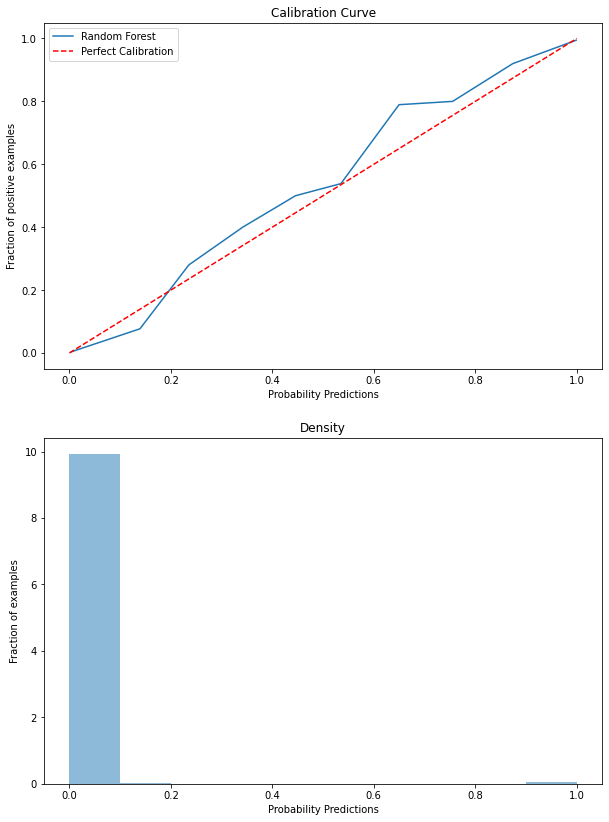

In [24]:
# for Logistic Model - SMOTE
# first fit log model on rus data
logit.fit(X_sm,y_sm)

# create a calibrated classifier on that model
clf = CalibratedClassifierCV(base_estimator=logit, n_jobs=2, cv=5, method='isotonic')

# fitting the clf to our test data
clf.fit(X_test,y_test) 
# get the predictions
preds = clf.predict_proba(X_test)[:,1]

# plotting the calibration curve
plot_calibration_curve(y_test,preds,bins=10)

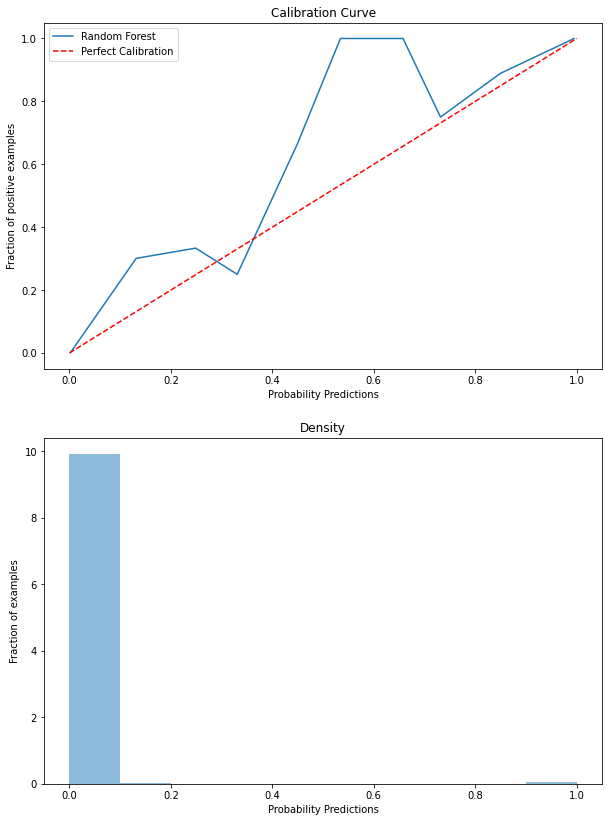

In [25]:
# for RF Model - SMOTE
# first fit log model on rus data
rf.fit(X_sm,y_sm)

# create a calibrated classifier on that model
clf = CalibratedClassifierCV(base_estimator=rf, n_jobs=2, cv=5, method='isotonic')

# fitting the clf to our test data
clf.fit(X_test,y_test) 
# get the predictions
preds = clf.predict_proba(X_test)[:,1]

# plotting the calibration curve
plot_calibration_curve(y_test,preds,bins=10)

- As expected, now we can see much better calibrated probabilities for both the models that are trained on the synthetic data as well